<a href="https://colab.research.google.com/github/davetew/EnergyMarketTools/blob/master/INTEGRATE_Phase_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTEGRATE Phase II
This notebook is intended to contain simple value proposition assessments for INTEGRATE systems in potential system applications.  Three broad categories will be considered--

1.   Distributed Generation
2.   Transportation
3.   Storage / (Electricity to Fuel Conversion)

The general value proposition for INTEGRATE-type systems is expected to be driven by the high efficiency conversion of--

1.   Fuel to electric power or
2.   Electric power to fuel


In [1]:
"""Import the required modules"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import pickle

"""Install, import, and configure 'pint' -- a physical quantity manipulation package"""
!pip install pint
import pint

# Save default unit registry in ureg & Quantity in Q_
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Define a currency dimension with usd (US dollar) as the base unit
ureg.define('usd = [currency]')

# Define a well dimension with wells as the base unit
ureg.define('well = [well]')

# Ignore pint unit strip warnings
import warnings
warnings.filterwarnings("ignore", message="The unit of the quantity is stripped.")

# Install the FRED API (St. Louis Federal Reserve Bank)
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='74dc0c0ba5a6d1d5c0e3704cee396565')
data = fred.get_series('SP500')

# Install EIA Github library
#!pip install git+https://github.com/davetew/EnergyMarketTools.git
!pip install --upgrade git+https://github.com/davetew/EnergyMarketTools.git

from EnergyMarketTools.EIADataQuery_pd import EIAQuery, EIAStateQuery
from EnergyMarketTools.DGValueProp import SensitivityStudy
from EnergyMarketTools.DGMarketStudy import MarketStudy
from EnergyMarketTools.getAnnualCPI import getAnnualCPI

  Cloning https://github.com/davetew/EnergyMarketTools.git to /tmp/pip-req-build-i8934dl1
  Running command git clone -q https://github.com/davetew/EnergyMarketTools.git /tmp/pip-req-build-i8934dl1
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4m64tc3/wheels/3e/4b/95/c9c1f4ba83436e1de4d5495447bbf5e043d8f7b98ef99fb7d8
Successfully built EnergyMarketTools
  Found existing installation: EnergyMarketTools 0.1
    Uninstalling EnergyMarketTools-0.1:
      Successfully uninstalled EnergyMarketTools-0.1


## Distributed Generation
The distributed generation value proposition was assessed in detailed during the development of the INTEGRATE program and was used to set the efficiency (>70\%), cost (<\\$1800/kW installed), maintenance (<\$0.02/kWh), and life (>20 years) targets for the systems.  However, the value proposition will be updated below using the latest energy rates.

Distributed generation systems create economic value for their owners/operators by generating electricity from natural gas at a levelized cost that is lower than the prevailing (industrial, commercial, or residential) electric rate.

Consequently, the high the difference between the natural gas and grid electric rates (i.e. the spark spread), the greater the potential economic value of the distributed generation system.

An effective spread that properly captures the fuel to electric conversion efficiency of electric-only DG systems is defined as--

$$s_{effective} = c_{electric} - \frac{c_{gas}}{\eta_{electric}}$$

$c_{electric}$ is the cost of grid electricity; $c_{gas}$ is the cost of natural gas; and $\eta_{electric}$ is the fuel to electric conversion efficiency of the distributed generation system.


   Successfully retrieved--> Electricity price in the commercial sector, United States
   Successfully retrieved--> Natural gas price in the commercial sector, United States
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, United States


(-0.043555111782183055, 0.1125690419365837)

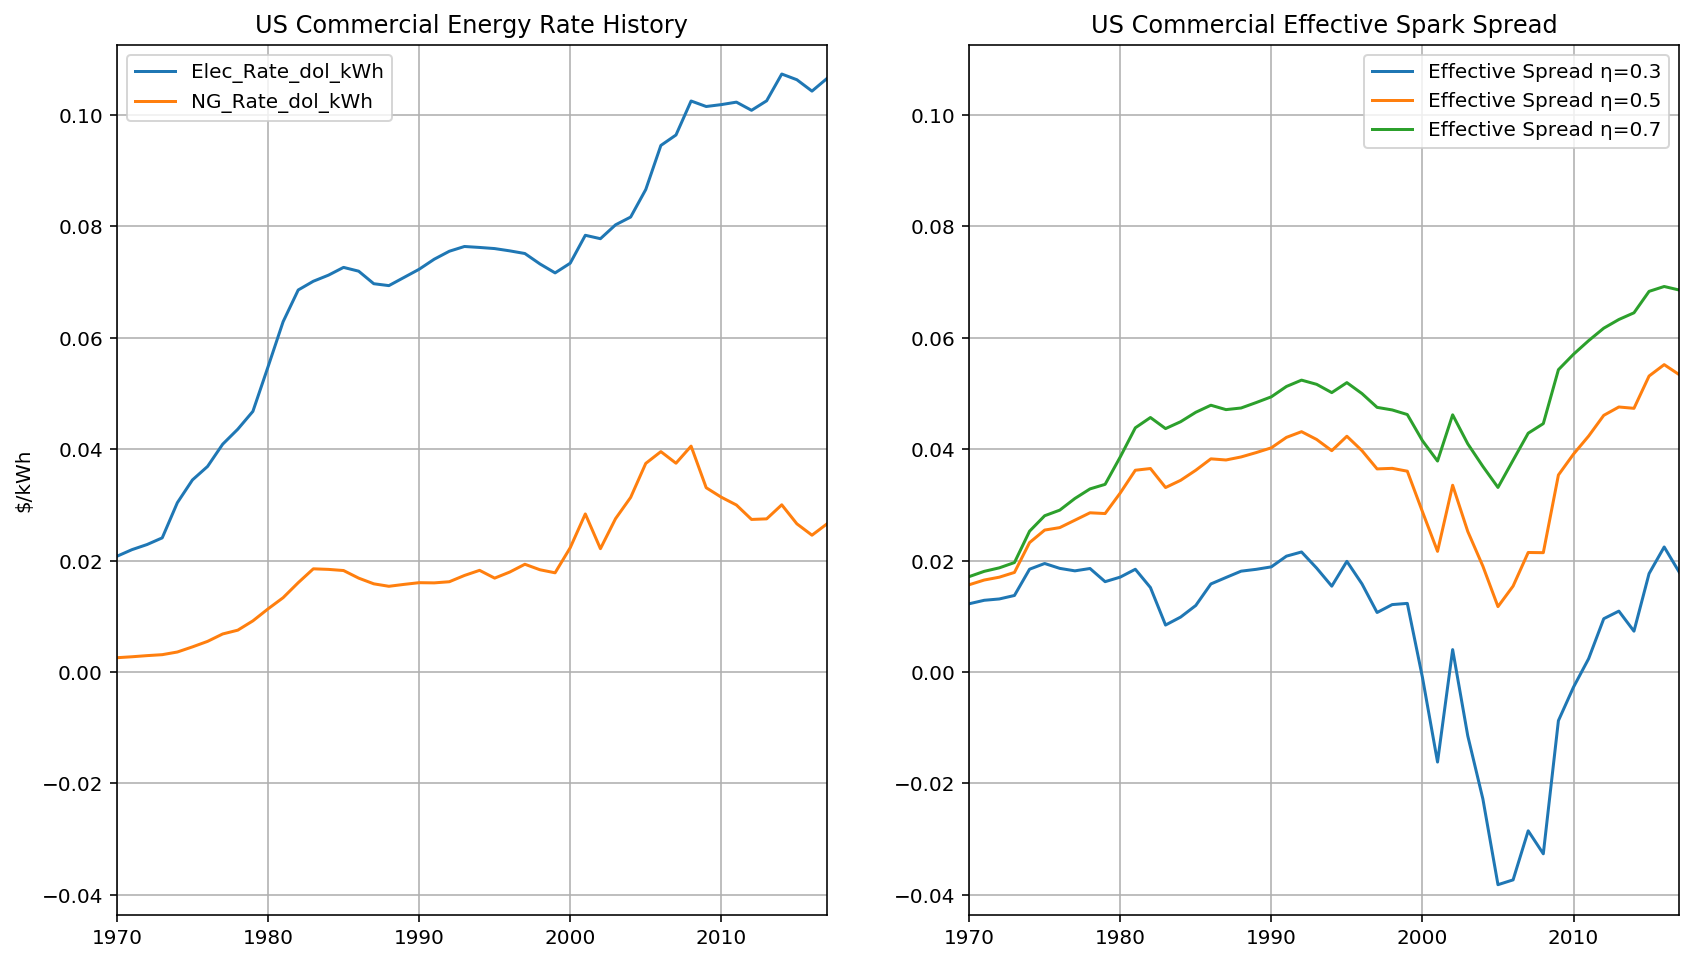

In [2]:
#@title Historical Spark Spread
#@markdown In the two figures below, historical US-average commercial electric and natural gas rates and the resulting effective spark spreads are plotted for three different electric efficiencies.
CommRates = EIAStateQuery('US')
CommRates.DataFrame = CommRates.DataFrame.dropna(axis=0)

fig=plt.figure(figsize=(14,8))
ax1, ax2 = plt.subplot(121), plt.subplot(1,2,2)

CommRates.DataFrame.plot(y=['Elec_Rate_dol_kWh','NG_Rate_dol_kWh'], 
                         ax=ax1, grid=True, 
                         title='US Commercial Energy Rate History')
ax1.set_ylabel('$/kWh')

EffSpreadHeader = []
for η in [0.3, 0.5, 0.7]:
  EffSpreadHeader.append(f'Effective Spread η={η}')
  CommRates.DataFrame[EffSpreadHeader[-1]] = CommRates.DataFrame['Elec_Rate_dol_kWh'] - CommRates.DataFrame['NG_Rate_dol_kWh'] / η
  
CommRates.DataFrame.plot(y=EffSpreadHeader, ax=ax2, grid=True,
                         title='US Commercial Effective Spark Spread')

# Set consistent y-axis limits
ylim = ( np.amin([ax1.get_ylim()[0], ax2.get_ylim()[0]]), 
          np.amax([ax1.get_ylim()[1], ax2.get_ylim()[1]]) )
ax1.set_ylim(ylim); ax2.set_ylim(ylim)

In [0]:
def getAnnualCPI(SeriesNames=['CPALTT01USA661S', 'USACPICORAINMEI'], 
                 SeriesLabels=['All Items', 'No Food or Energy'],
                 displayData=False, plotData=False):
  """Get and return a dataframe with US Annual CPIs and their associated labels"""
  
  # Get the CPI data from Fred and store it in a dictionary using the labes as keys
  cpi = {}
  for Name, Label in zip(SeriesNames, SeriesLabels):
    cpi[Label] = fred.get_series(Name)
    cpi[Label].index = cpi[Label].index.map(lambda x: x.year)

  # Create a dataframe with all the data
  cpi_df = pd.DataFrame.from_dict(cpi).dropna()

  # Normalized the index (i.e. divide by 100)
  cpi_df = cpi_df.apply(lambda x: x/100)

  if displayData: display(cpi_df)
  if plotData: cpi_df.plot(grid=True, title='US CPI')

  return cpi_df

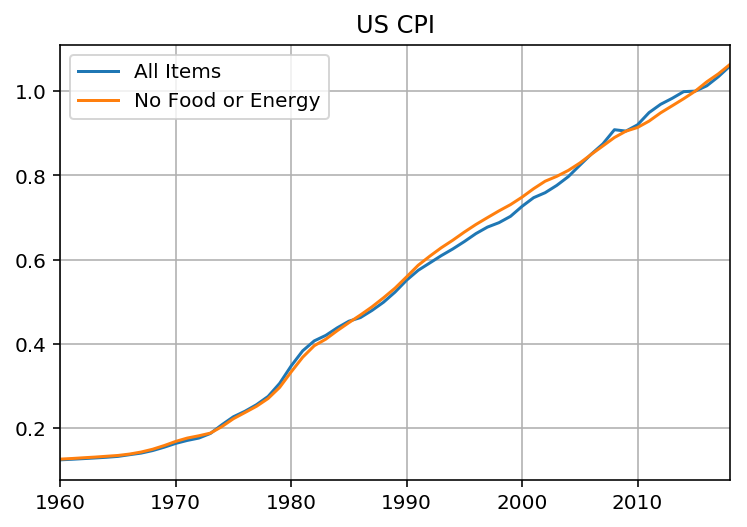

In [4]:
#@title US Consumer Price Index

# Get the US Annual CPI data from FRED
cpi = getAnnualCPI(displayData=False, plotData=True)

(-0.03687956752562162, 0.11643449263800253)

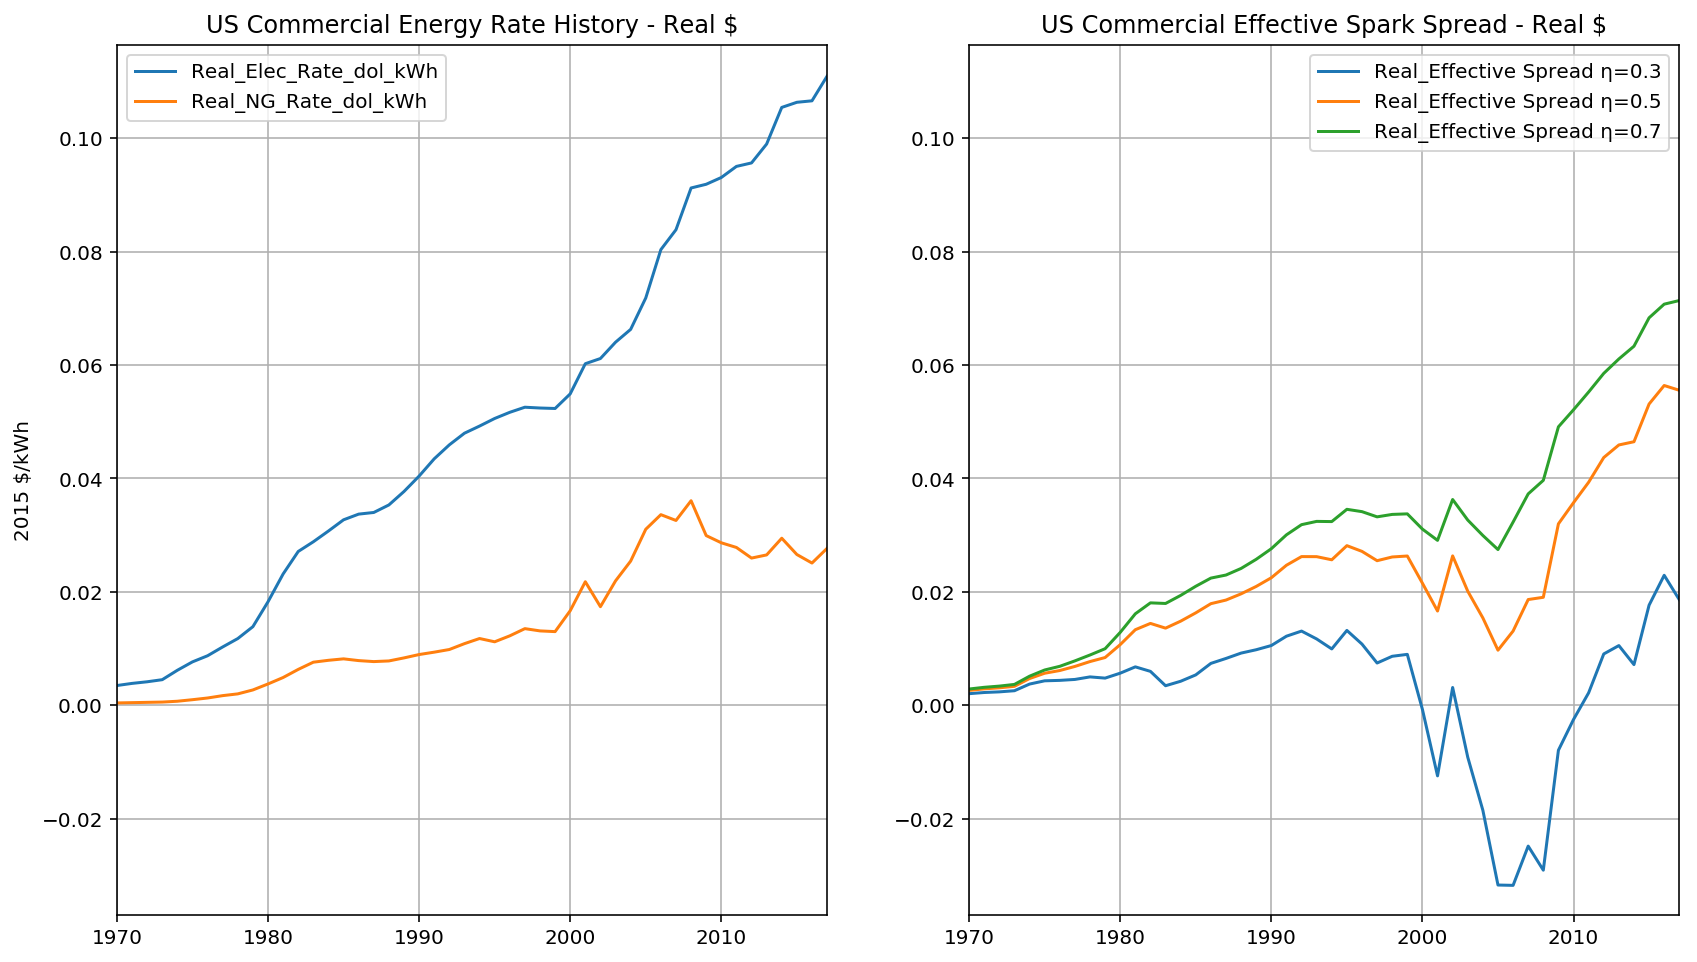

In [5]:
# Merge the CPI data into the energy rate dataframe
OrigColumns = list(CommRates.DataFrame.columns)
CommRates.DataFrame = CommRates.DataFrame.join(cpi)

for OrigCol in OrigColumns:
  if OrigCol is not "Elec_Consumption_kWh":
    CommRates.DataFrame['Real_' + OrigCol] = CommRates.DataFrame[OrigCol]*CommRates.DataFrame['No Food or Energy']

# Plot the real rates
fig=plt.figure(figsize=(14,8))
ax1, ax2 = plt.subplot(121), plt.subplot(1,2,2)

CommRates.DataFrame.plot(y=['Real_Elec_Rate_dol_kWh','Real_NG_Rate_dol_kWh'], 
                         ax=ax1, grid=True, 
                         title='US Commercial Energy Rate History - Real $')
ax1.set_ylabel('2015 $/kWh')
  
CommRates.DataFrame.plot(y=['Real_' + efs for efs in EffSpreadHeader], ax=ax2, grid=True,
                         title='US Commercial Effective Spark Spread - Real $')

# Set consistent y-axis limits
ylim = ( np.amin([ax1.get_ylim()[0], ax2.get_ylim()[0]]), 
          np.amax([ax1.get_ylim()[1], ax2.get_ylim()[1]]) )
ax1.set_ylim(ylim); ax2.set_ylim(ylim)

   Successfully retrieved--> Electricity price in the commercial sector, United States
   Successfully retrieved--> Natural gas price in the commercial sector, United States
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, United States


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f888b0bd7f0>)

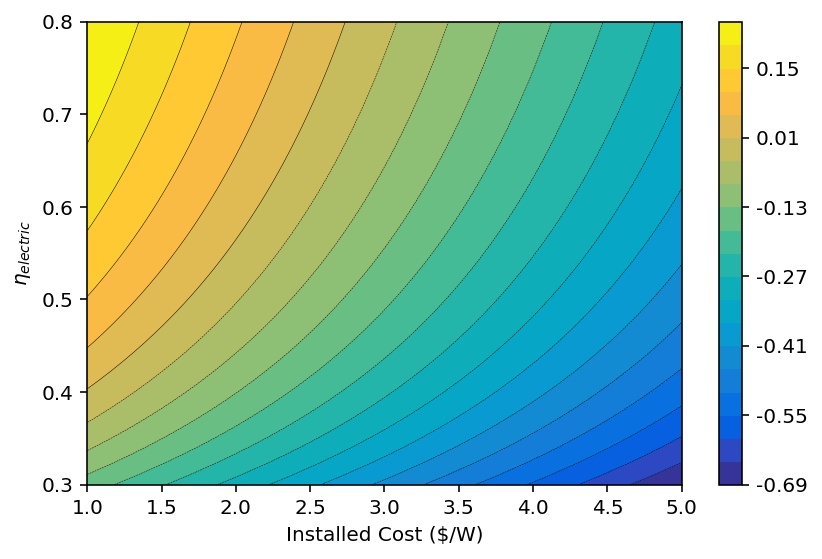

In [6]:
# Complete DG Sensitivity Study
DG = SensitivityStudy(Year=2017, y_param_name='electric_efficiency', y_param_values=np.linspace(0.3, 0.8, 50), 
                      x_param_name='installed_price_dol_W', x_param_values=np.linspace(1.0, 5.0, 50))
DG.contour_plot()

In [7]:
"""Execute Commercial CHP Market Assessment"""

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

sector = 'COM'
year = 2017
region = None
study_name = 'ComMarketStudy_' + str(year) + '.dat'

       
US_Market_Eval = MarketStudy(Regions=states, Years=[year], Sectors=[sector], 
                     x_param_name='electric_efficiency',
                     x_param_values=np.linspace(0.25,0.8,100),
                     y_param_name='installed_price_dol_W',
                     y_param_values=np.logspace(np.log10(0.2),np.log10(5),100),
                     electric_efficiency = 0.4,
                     thermal_efficiency = '(1-electric_efficiency)/2',
                     installed_price_dol_W = 3,
                     maint_cost_dol_kWh = 0.02,
                     life_yrs = 20,
                     elec_capacity_utilization = 0.80,
                     therm_capacity_utilization = 0.50,
                     baseline_thermal_efficiency = 0.9,
                     inflation_rate = 0.02,
                     discount_rate = 0.15,
                     grid_baseline_elec_efficiency=0.34)


   Successfully retrieved--> Electricity price in the commercial sector, Alabama
   Successfully retrieved--> Natural gas price in the commercial sector, Alabama
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, Alabama
   Successfully retrieved--> Electricity price in the commercial sector, Alaska
   Successfully retrieved--> Natural gas price in the commercial sector, Alaska
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, Alaska
   Successfully retrieved--> Electricity price in the commercial sector, Arizona
   Successfully retrieved--> Natural gas price in the commercial sector, Arizona
   Successfully retrieved--> Electricity consumed by (i.e., sold to) the commercial sector, Arizona
   Successfully retrieved--> Electricity price in the commercial sector, Arkansas
   Successfully retrieved--> Natural gas price in the commercial sector, Arkansas
   Successfully retrieved--> Electricity consumed by 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f887933d978>)

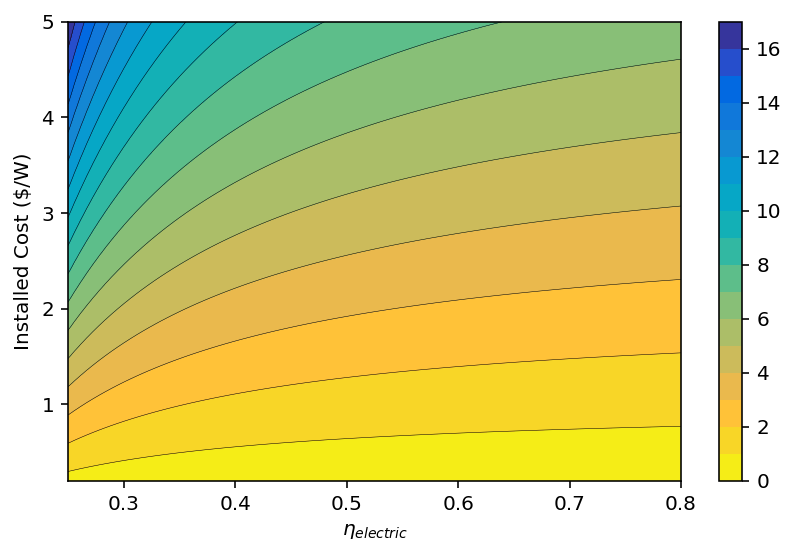

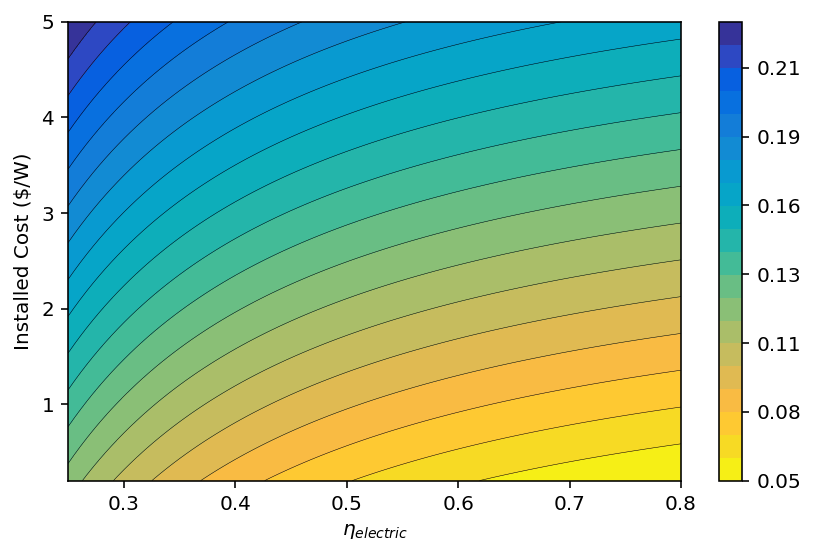

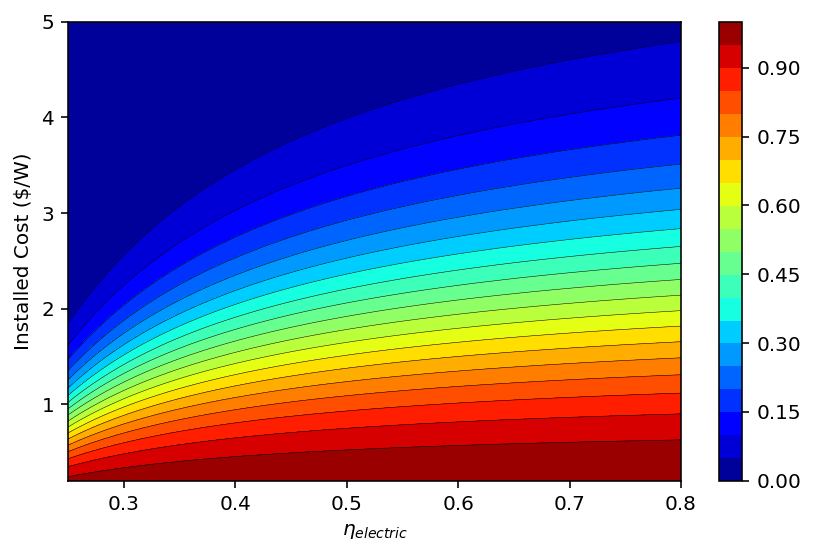

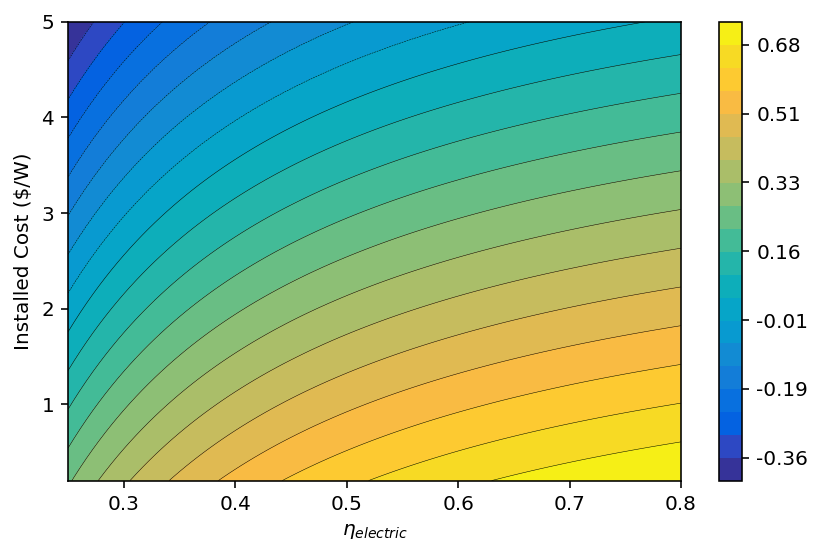

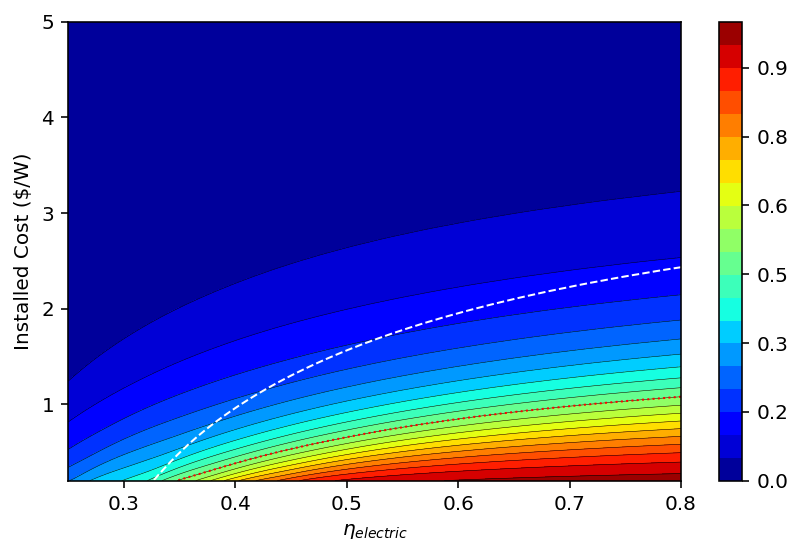

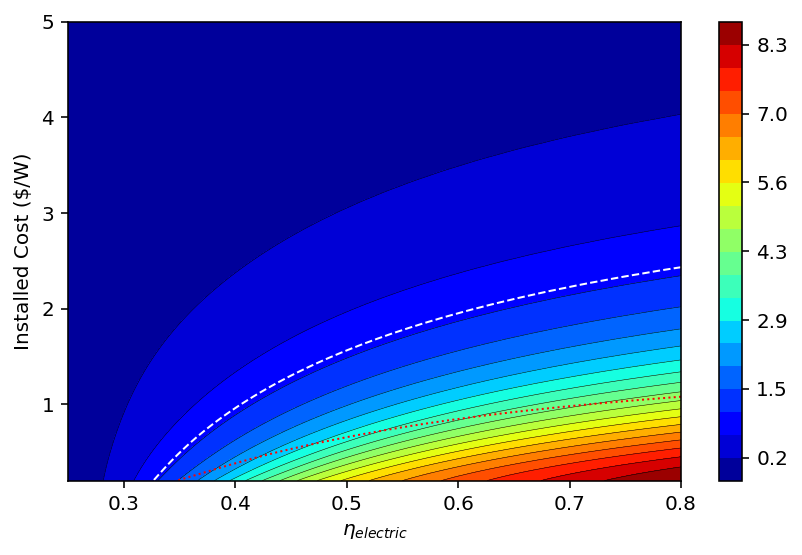

In [8]:
pickle.dump(US_Market_Eval,open(study_name,'wb'))

region = 'CA'
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='PB_yrs')
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='LCOE_dol_kWh')
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='MaxMarketPen')
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='NPV_dol_kWh')
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='TotalMarketPen')
US_Market_Eval.contour_plot(sector=sector,year=year,region=region,metric='PrimaryEnergySavings_Quads')

## Transportation
In this section, the value proposition for high efficiency fuel to electric power conversion systems will be evaluated in three different transportation applications:


1.   Aviation
2.   Marine
3.   Rail

In each of the transportation applications, system weight and/or volume will also be an important element of the value proposition for the system.


### Marine
In this section, the value proposition for an ultra-efficient marine propulsion system will be assessed.

Bunker-fuel powered internal combustion engines are the status quo energy storage and conversion technologies for the cargo ship market.

Bunker fuel represents the heaviest cut of crude and can have a high sulfur content.

However, LNG and and other lower sulfur fuels have been gaining due to regulatory changes and emissions-related environmental concerns.

'Bunker Fuel Cost = 0.03130434782608696 usd / kilowatt_hour'

   Successfully retrieved--> Price of U.S. Natural Gas Imports, Annual


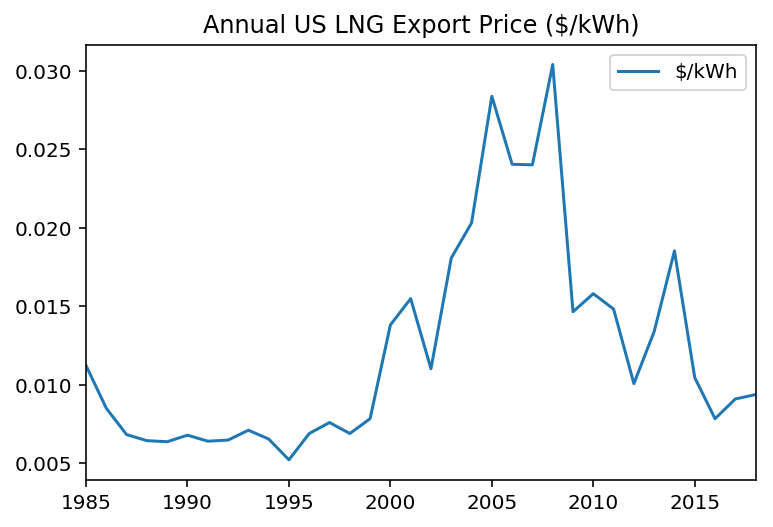

In [12]:
Bunker_Fuel_Cost_MassSpecific = Q_(400, 'usd/tonne')
Bunker_Fuel_LHV = Q_(46, 'MJ/kg')

Bunker_Fuel_Cost_EnergySpecific = (Bunker_Fuel_Cost_MassSpecific / Bunker_Fuel_LHV).to('usd/kWh')
display(f'Bunker Fuel Cost = {Bunker_Fuel_Cost_EnergySpecific}')

# Get the LNG export price from the EIA
LNG_Export_Price = EIAQuery('NG.N9100US3.A')
LNG_Export_Price.DataFrame.plot(title='Annual US LNG Export Price ($/kWh)')



Bunker fuel has an energy-specific cost of {{Bunker_Fuel_Cost_EnergySpecific}}.

## Storage / Fuel Production from Renewable Sources

In [11]:
# Total US NG production rate from the EIA (2017)
US_NG_Production_Rate_Volume = Q_(97*10**9, 'ft**3/day')
NG_HHV = Q_(1000, 'Btu/ft**3')

US_NG_Production_Rate_Energy = ( US_NG_Production_Rate_Volume * NG_HHV).to('TW')
display(f'US_NG_Production_Rate_Energy = {US_NG_Production_Rate_Energy}')

# Total # of US gas wells from the EIA (2017)
Number_of_Gas_Wells = Q_(486258, 'wells')

Energy_Production_Rate_per_Well = (US_NG_Production_Rate_Energy / Number_of_Gas_Wells).to('MW/well')
display(f'Energy_Production_Rate_per_Well = {Energy_Production_Rate_per_Well}')

# Average life of a NG well
Life = Q_(25, 'years')

# Natural gas price
HH_Gas_Price = Q_(2.33, 'usd/MBtu')
display(f'HH_Gas_Price = {HH_Gas_Price} = {HH_Gas_Price.to("usd/MWh")}')

# Annual value of NG production per well
Monetary_Production_Rate_per_Well = (Energy_Production_Rate_per_Well * HH_Gas_Price).to('usd/year/well')
display(f'Monetary_Production_Rate_per_Well = {Monetary_Production_Rate_per_Well}')

'US_NG_Production_Rate_Energy = 1.184495575279398 terawatt'

'Energy_Production_Rate_per_Well = 2.4359405403703343 megawatt / well'

'HH_Gas_Price = 2.33 usd / megabtu = 7.950290005188104 usd / megawatt_hour'

'Monetary_Production_Rate_per_Well = 169762.53212605303 usd / well / year'